# **Extraction des Time Series**

In [ ]:
import os
from pathlib import Path
from urllib.parse import urlparse
import re
import sys
import time

import requests
from bs4 import BeautifulSoup

from tqdm import tqdm
import concurrent.futures
from threading import Lock

import pandas as pd
from collections import defaultdict

In [ ]:
"""
Scrape tous les liens 'tesscurl_sector_<N>_tp.sh' depuis le HTML MAST local
et télécharge chaque script dans data/TESS/sh.

Entrée par défaut : "TESS - FFI_TP_LC Bulk Downloads.html"
Sortie           : data/TESS/sh/tesscurl_sector_<N>_tp.sh
"""

HTML_INPUT = Path("data/TESS/TESS - FFI_TP_LC Bulk Downloads.html")   # adapte si besoin
OUT_DIR    = Path("data/TESS/sh")
HREF_LC_RE    = re.compile(r"/tesscurl_sector_(\d+)_lc\.sh$", re.I)
HREF_DV_RE    = re.compile(r"/tesscurl_sector_(\d+)_dv\.sh$", re.I)

In [51]:
def check_html_file(html_path: Path):
    if not html_path.exists():
        print(f"Fichier HTML introuvable: {html_path}", file=sys.stderr)
        return False
    return True

In [ ]:
def find_links(html_path: Path, HREF_RE: re.Pattern):
    html = html_path.read_text(encoding="utf-8", errors="ignore")
    soup = BeautifulSoup(html, "html.parser")
    links = []
    for a in soup.find_all("a", href=True):
        href = a["href"].strip()
        if HREF_RE.search(href):
            links.append(href)
    # normalise en absolu si la page a des URLs relatives
    # Déduplique en conservant l'ordre d'apparition
    seen = set()
    uniq = []
    for h in links:
        if h not in seen:
            uniq.append(h)
            seen.add(h)
    return uniq

In [53]:
def check_links(links: list[str], label: str):
    if not links:
        print(f"Aucun lien {label}.sh trouvé dans la page. Vérifie le fichier HTML.", file=sys.stderr)
        return False

    print(f"Liens {label} trouvés: {len(links)}")
    return True

In [54]:
def safe_filename_from_url(url: str) -> str:
    name = Path(urlparse(url).path).name
    # garde exactement "tesscurl_sector_<N>_tp.sh"
    return name

In [55]:
def download(url: str, dest: Path, max_retries: int = 3, timeout: int = 30):
    dest.parent.mkdir(parents=True, exist_ok=True)
    # reprise: si déjà présent et non-vide, ne pas retélécharger
    if dest.exists() and dest.stat().st_size > 0:
        return "skip"
    last_exc = None
    for attempt in range(1, max_retries + 1):
        try:
            with requests.get(url, stream=True, timeout=timeout) as r:
                r.raise_for_status()
                tmp = dest.with_suffix(dest.suffix + ".part")
                with open(tmp, "wb") as f:
                    for chunk in r.iter_content(chunk_size=1 << 15):
                        if chunk:
                            f.write(chunk)
                tmp.replace(dest)
            return "ok"
        except Exception as e:
            last_exc = e
            time.sleep(1.5 * attempt)
    raise RuntimeError(f"Echec téléchargement après {max_retries} essais: {url}\n{last_exc}")

In [56]:
def get_sh_files(links: list[str]):
    n_ok = n_skip = 0
    for url in links:
        fname = safe_filename_from_url(url)
        dest  = OUT_DIR / fname
        status = download(url, dest)
        if status == "ok":
            n_ok += 1
            print(f"[OK] {fname}")
        else:
            n_skip += 1
            print(f"[SKIP] {fname} déjà présent")
    print(f"Terminé. Nouveaux: {n_ok}, Skippés: {n_skip}. Dossier: {OUT_DIR.resolve()}")

In [57]:
def main_scrap():
    if check_html_file(HTML_INPUT) is False:
        return 84

    lc_links = find_links(HTML_INPUT, HREF_LC_RE)
    dv_links = find_links(HTML_INPUT, HREF_DV_RE)
    if check_links(lc_links, "LC") is False or check_links(dv_links, "DV") is False:
        return 84
    
    get_sh_files(lc_links)
    get_sh_files(dv_links)


In [58]:
main_scrap()

Liens LC trouvés: 95
Liens DV trouvés: 95
[OK] tesscurl_sector_95_lc.sh
[OK] tesscurl_sector_94_lc.sh
[OK] tesscurl_sector_93_lc.sh
[OK] tesscurl_sector_92_lc.sh
[OK] tesscurl_sector_91_lc.sh
[OK] tesscurl_sector_90_lc.sh
[OK] tesscurl_sector_89_lc.sh
[OK] tesscurl_sector_88_lc.sh
[OK] tesscurl_sector_87_lc.sh
[OK] tesscurl_sector_86_lc.sh
[OK] tesscurl_sector_85_lc.sh
[OK] tesscurl_sector_84_lc.sh
[OK] tesscurl_sector_83_lc.sh
[OK] tesscurl_sector_82_lc.sh
[OK] tesscurl_sector_81_lc.sh
[OK] tesscurl_sector_80_lc.sh
[OK] tesscurl_sector_79_lc.sh
[OK] tesscurl_sector_78_lc.sh
[OK] tesscurl_sector_77_lc.sh
[OK] tesscurl_sector_76_lc.sh
[OK] tesscurl_sector_75_lc.sh
[OK] tesscurl_sector_74_lc.sh
[OK] tesscurl_sector_73_lc.sh
[OK] tesscurl_sector_72_lc.sh
[OK] tesscurl_sector_71_lc.sh
[OK] tesscurl_sector_70_lc.sh
[OK] tesscurl_sector_69_lc.sh
[OK] tesscurl_sector_68_lc.sh
[OK] tesscurl_sector_67_lc.sh
[OK] tesscurl_sector_66_lc.sh
[OK] tesscurl_sector_65_lc.sh
[OK] tesscurl_sector_64_lc.s

### **Arrivé ici, tout les fichiers lc.sh et dv.sh ont été téléchargés dans data/TESS/sh**

Nous voulons maintenant télécharger les LC cibles qui sont également présent dans les DV

In [9]:
def extract_tic_from_filename(filename):
    """
    Extrait le TIC depuis le nom de fichier TESS.
    Format: tess*-s*-*TIC*-*-s_lc.fits ou tess*-s*-s*-*TIC*-*-*_dv*.fits
    """
    pattern = r"-0+(\d+)-"
    match = re.search(pattern, filename)
    if match:
        return int(match.group(1))
    return None


In [10]:
def parse_sh_file(file_path):
    """
    Parse un fichier .sh et extrait les URLs et informations des cibles.
    """
    targets = []
    
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('curl'):
                # Extraire l'URL depuis la ligne curl
                url_match = re.search(r'https://[^\s]+', line)
                if url_match:
                    url = url_match.group(0)
                    # Extraire le nom de fichier depuis l'URL
                    filename_match = re.search(r'/([^/]+\.fits)', url)
                    if filename_match:
                        filename = filename_match.group(1)
                        tic = extract_tic_from_filename(filename)
                        if tic:
                            targets.append({
                                'filename': filename,
                                'url': url,
                                'tic': tic
                            })
    
    return targets


In [11]:
def process_sh_files(sh_dir, pattern):
    """
    Traite tous les fichiers .sh correspondant au pattern et retourne un DataFrame.
    """
    sh_dir = Path(sh_dir)
    all_targets = []
    
    # Trouver tous les fichiers correspondant au pattern
    sh_files = list(sh_dir.glob(pattern))
    print(f"Trouvé {len(sh_files)} fichiers {pattern}")
    
    for sh_file in sh_files:
        print(f"Traitement de {sh_file.name}...")
        targets = parse_sh_file(sh_file)
        all_targets.extend(targets)
    
    # Créer un DataFrame
    df = pd.DataFrame(all_targets)
    
    if not df.empty:
        # Supprimer les doublons basés sur le TIC
        df = df.drop_duplicates(subset=['tic'])
        df = df.sort_values('tic').reset_index(drop=True)
    
    return df


In [14]:
# Traitement des fichiers LC
print("=== TRAITEMENT DES FICHIERS LC ===")
lc_df = process_sh_files("data/TESS/sh", "*lc.sh")


=== TRAITEMENT DES FICHIERS LC ===
Trouvé 95 fichiers *lc.sh
Traitement de tesscurl_sector_71_lc.sh...
Traitement de tesscurl_sector_69_lc.sh...
Traitement de tesscurl_sector_34_lc.sh...
Traitement de tesscurl_sector_40_lc.sh...
Traitement de tesscurl_sector_32_lc.sh...
Traitement de tesscurl_sector_13_lc.sh...
Traitement de tesscurl_sector_85_lc.sh...
Traitement de tesscurl_sector_87_lc.sh...
Traitement de tesscurl_sector_61_lc.sh...
Traitement de tesscurl_sector_92_lc.sh...
Traitement de tesscurl_sector_41_lc.sh...
Traitement de tesscurl_sector_36_lc.sh...
Traitement de tesscurl_sector_54_lc.sh...
Traitement de tesscurl_sector_23_lc.sh...
Traitement de tesscurl_sector_39_lc.sh...
Traitement de tesscurl_sector_93_lc.sh...
Traitement de tesscurl_sector_80_lc.sh...
Traitement de tesscurl_sector_6_lc.sh...
Traitement de tesscurl_sector_18_lc.sh...
Traitement de tesscurl_sector_42_lc.sh...
Traitement de tesscurl_sector_5_lc.sh...
Traitement de tesscurl_sector_37_lc.sh...
Traitement de tes

In [15]:
print(f"\nRésumé des cibles LC:")
print(f"- Nombre total de cibles LC: {len(lc_df)}")
print(f"- TIC min: {lc_df['tic'].min() if not lc_df.empty else 'N/A'}")
print(f"- TIC max: {lc_df['tic'].max() if not lc_df.empty else 'N/A'}")

# Afficher les premières lignes
if not lc_df.empty:
    print(f"\nPremières cibles LC:")
    print(lc_df.head())


Résumé des cibles LC:
- Nombre total de cibles LC: 554526
- TIC min: 101
- TIC max: 10005000540

Premières cibles LC:
                                            filename  \
0  tess2021118034608-s0038-0000000000000101-0209-...   
1  tess2021118034608-s0038-0000000000000185-0209-...   
2  tess2021118034608-s0038-0000000000000358-0209-...   
3  tess2021118034608-s0038-0000000000000382-0209-...   
4  tess2019112060037-s0011-0000000000001078-0143-...   

                                                 url   tic  
0  https://mast.stsci.edu/api/v0.1/Download/file/...   101  
1  https://mast.stsci.edu/api/v0.1/Download/file/...   185  
2  https://mast.stsci.edu/api/v0.1/Download/file/...   358  
3  https://mast.stsci.edu/api/v0.1/Download/file/...   382  
4  https://mast.stsci.edu/api/v0.1/Download/file/...  1078  


In [16]:
# Traitement des fichiers DV
print("\n=== TRAITEMENT DES FICHIERS DV ===")
dv_df = process_sh_files("data/TESS/sh", "*dv.sh")


=== TRAITEMENT DES FICHIERS DV ===
Trouvé 95 fichiers *dv.sh
Traitement de tesscurl_sector_55_dv.sh...
Traitement de tesscurl_sector_58_dv.sh...
Traitement de tesscurl_sector_88_dv.sh...
Traitement de tesscurl_sector_60_dv.sh...
Traitement de tesscurl_sector_44_dv.sh...
Traitement de tesscurl_sector_91_dv.sh...
Traitement de tesscurl_sector_28_dv.sh...
Traitement de tesscurl_sector_64_dv.sh...
Traitement de tesscurl_sector_48_dv.sh...
Traitement de tesscurl_sector_50_dv.sh...
Traitement de tesscurl_sector_70_dv.sh...
Traitement de tesscurl_sector_4_dv.sh...
Traitement de tesscurl_sector_94_dv.sh...
Traitement de tesscurl_sector_87_dv.sh...
Traitement de tesscurl_sector_16_dv.sh...
Traitement de tesscurl_sector_68_dv.sh...
Traitement de tesscurl_sector_76_dv.sh...
Traitement de tesscurl_sector_78_dv.sh...
Traitement de tesscurl_sector_15_dv.sh...
Traitement de tesscurl_sector_12_dv.sh...
Traitement de tesscurl_sector_67_dv.sh...
Traitement de tesscurl_sector_52_dv.sh...
Traitement de t

In [17]:
print(f"\nRésumé des cibles DV:")
print(f"- Nombre total de cibles DV: {len(dv_df)}")
print(f"- TIC min: {dv_df['tic'].min() if not dv_df.empty else 'N/A'}")
print(f"- TIC max: {dv_df['tic'].max() if not dv_df.empty else 'N/A'}")

# Afficher les premières lignes
if not dv_df.empty:
    print(f"\nPremières cibles DV:")
    print(dv_df.head())


Résumé des cibles DV:
- Nombre total de cibles DV: 41193
- TIC min: 358
- TIC max: 10002013421

Premières cibles DV:
                                            filename  \
0  tess2021119082105-s0038-s0038-0000000000000358...   
1  tess2021119082105-s0038-s0038-0000000000001886...   
2  tess2025099184928-s0091-s0091-0000000000002876...   
3  tess2025099184928-s0091-s0091-0000000000004711...   
4  tess2025099184928-s0091-s0091-0000000000017361...   

                                                 url    tic  
0  https://mast.stsci.edu/api/v0.1/Download/file/...    358  
1  https://mast.stsci.edu/api/v0.1/Download/file/...   1886  
2  https://mast.stsci.edu/api/v0.1/Download/file/...   2876  
3  https://mast.stsci.edu/api/v0.1/Download/file/...   4711  
4  https://mast.stsci.edu/api/v0.1/Download/file/...  17361  


In [18]:
# Sauvegarde des tables
print("\n=== SAUVEGARDE DES TABLES ===")

# Sauvegarder les tables LC et DV
if not lc_df.empty:
    lc_df.to_csv("data/TESS/lc_targets.csv", index=False)
    print(f"Table LC sauvegardée: data/TESS/lc_targets.csv ({len(lc_df)} cibles)")

if not dv_df.empty:
    dv_df.to_csv("data/TESS/dv_targets.csv", index=False)
    print(f"Table DV sauvegardée: data/TESS/dv_targets.csv ({len(dv_df)} cibles)")

print("\nTables créées avec succès!")



=== SAUVEGARDE DES TABLES ===
Table LC sauvegardée: data/TESS/lc_targets.csv (554526 cibles)
Table DV sauvegardée: data/TESS/dv_targets.csv (41193 cibles)

Tables créées avec succès!


In [19]:
# Comparaison des TIC entre LC et DV
print("\n=== COMPARAISON DES TIC LC ET DV ===")

if not lc_df.empty and not dv_df.empty:
    # Trouver les TIC communs
    lc_tics = set(lc_df['tic'])
    dv_tics = set(dv_df['tic'])
    
    common_tics = lc_tics.intersection(dv_tics)
    lc_only_tics = lc_tics - dv_tics
    dv_only_tics = dv_tics - lc_tics
    
    print(f"Statistiques de comparaison:")
    print(f"- TIC dans LC uniquement: {len(lc_only_tics)}")
    print(f"- TIC dans DV uniquement: {len(dv_only_tics)}")
    print(f"- TIC communs (LC ∩ DV): {len(common_tics)}")
    print(f"- Total TIC LC: {len(lc_tics)}")
    print(f"- Total TIC DV: {len(dv_tics)}")
    
    # Filtrer les cibles LC pour ne garder que celles présentes dans DV
    lc_filtered_df = lc_df[lc_df['tic'].isin(common_tics)].copy()
    lc_filtered_df = lc_filtered_df.sort_values('tic').reset_index(drop=True)
    
    print(f"\nCibles LC filtrées (présentes dans DV): {len(lc_filtered_df)}")
    
    # Sauvegarder la table filtrée
    if not lc_filtered_df.empty:
        lc_filtered_df.to_csv("data/TESS/lc_targets_filtered.csv", index=False)
        print(f"Table LC filtrée sauvegardée: data/TESS/lc_targets_filtered.csv")
        
        # Afficher quelques exemples
        print(f"\nExemples de cibles LC filtrées:")
        print(lc_filtered_df.head(10))
    
else:
    print("Erreur: Une des tables LC ou DV est vide!")



=== COMPARAISON DES TIC LC ET DV ===
Statistiques de comparaison:
- TIC dans LC uniquement: 513333
- TIC dans DV uniquement: 0
- TIC communs (LC ∩ DV): 41193
- Total TIC LC: 554526
- Total TIC DV: 41193

Cibles LC filtrées (présentes dans DV): 41193
Table LC filtrée sauvegardée: data/TESS/lc_targets_filtered.csv

Exemples de cibles LC filtrées:
                                            filename  \
0  tess2021118034608-s0038-0000000000000358-0209-...   
1  tess2021118034608-s0038-0000000000001886-0209-...   
2  tess2025099153000-s0091-0000000000002876-0288-...   
3  tess2025099153000-s0091-0000000000004711-0288-...   
4  tess2025099153000-s0091-0000000000017361-0288-...   
5  tess2021118034608-s0038-0000000000023369-0209-...   
6  tess2021118034608-s0038-0000000000031122-0209-...   
7  tess2021118034608-s0038-0000000000034900-0209-...   
8  tess2021118034608-s0038-0000000000042817-0209-...   
9  tess2021118034608-s0038-0000000000046937-0209-...   

                                   

## **Résumé du traitement**

Le script a été exécuté avec succès et a permis de :

1. **Extraire les cibles LC** : Parsing de tous les fichiers `*lc.sh` pour extraire les URLs et TIC des courbes de lumière
2. **Extraire les cibles DV** : Parsing de tous les fichiers `*dv.sh` pour extraire les URLs et TIC des données de validation
3. **Créer des tables** : Génération de fichiers CSV avec les informations extraites
4. **Comparer les TIC** : Identification des cibles communes entre LC et DV
5. **Filtrer les cibles LC** : Conservation uniquement des cibles LC qui sont également présentes dans les données DV

### **Fichiers générés :**
- `data/TESS/lc_targets.csv` : Toutes les cibles LC
- `data/TESS/dv_targets.csv` : Toutes les cibles DV  
- `data/TESS/lc_targets_filtered.csv` : Cibles LC filtrées (présentes dans DV)

Cette approche garantit que nous ne téléchargeons que les courbes de lumière pour les cibles qui ont également des données de validation disponibles.


## **Téléchargement des fichiers FITS**

Maintenant que nous avons identifié les cibles communes entre LC et DV, nous allons télécharger les fichiers FITS correspondants depuis les URLs du fichier CSV filtré.


In [30]:
def download_fits_file(url, filename, output_dir, max_retries=3, timeout=30):
    """
    Télécharge un fichier FITS depuis une URL vers le dossier de sortie.
    
    Args:
        url (str): URL du fichier FITS à télécharger
        filename (str): Nom du fichier FITS (depuis le CSV)
        output_dir (Path): Dossier de destination
        max_retries (int): Nombre maximum de tentatives
        timeout (int): Timeout en secondes
    
    Returns:
        dict: Résultat du téléchargement avec statut et informations
    """
    # Créer le dossier de sortie s'il n'existe pas
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Utiliser le nom de fichier fourni au lieu d'extraire depuis l'URL
    output_path = output_dir / filename
    
    # Si le fichier existe déjà et n'est pas vide, le skippe
    if output_path.exists() and output_path.stat().st_size > 0:
        return {
            'status': 'skipped',
            'filename': filename,
            'url': url,
            'path': str(output_path),
            'size': output_path.stat().st_size
        }
    
    last_exception = None
    
    for attempt in range(1, max_retries + 1):
        try:
            # Télécharger le fichier
            response = requests.get(url, stream=True, timeout=timeout)
            response.raise_for_status()
            
            # Écrire le fichier par chunks
            temp_path = output_path.with_suffix(output_path.suffix + '.part')
            with open(temp_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
            
            # Renommer le fichier temporaire
            temp_path.replace(output_path)
            
            return {
                'status': 'success',
                'filename': filename,
                'url': url,
                'path': str(output_path),
                'size': output_path.stat().st_size,
                'attempts': attempt
            }
            
        except Exception as e:
            last_exception = e
            if attempt < max_retries:
                time.sleep(2 ** attempt)  # Backoff exponentiel
    
    return {
        'status': 'failed',
        'filename': filename,
        'url': url,
        'error': str(last_exception),
        'attempts': max_retries
    }


In [31]:
def download_fits_batch(df_data, output_dir, max_workers=5, progress_bar=True):
    """
    Télécharge plusieurs fichiers FITS en parallèle.
    
    Args:
        df_data (DataFrame): DataFrame avec colonnes 'url' et 'filename'
        output_dir (Path): Dossier de destination
        max_workers (int): Nombre maximum de threads
        progress_bar (bool): Afficher la barre de progression
    
    Returns:
        dict: Statistiques du téléchargement
    """
    output_dir = Path(output_dir)
    results = []
    
    # Compteurs pour les statistiques
    stats = {
        'total': len(df_data),
        'success': 0,
        'skipped': 0,
        'failed': 0,
        'total_size': 0
    }
    
    # Lock pour les statistiques thread-safe
    stats_lock = Lock()
    
    def download_with_stats(row):
        url = row['url']
        filename = row['filename']
        result = download_fits_file(url, filename, output_dir)
        
        with stats_lock:
            if result['status'] == 'success':
                stats['success'] += 1
                stats['total_size'] += result.get('size', 0)
            elif result['status'] == 'skipped':
                stats['skipped'] += 1
                stats['total_size'] += result.get('size', 0)
            else:
                stats['failed'] += 1
        
        return result
    
    # Téléchargement en parallèle
    if progress_bar:
        with tqdm(total=len(df_data), desc="Téléchargement FITS") as pbar:
            with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
                # Soumettre toutes les tâches
                future_to_row = {executor.submit(download_with_stats, row): row for _, row in df_data.iterrows()}
                
                # Traiter les résultats au fur et à mesure
                for future in concurrent.futures.as_completed(future_to_row):
                    result = future.result()
                    results.append(result)
                    pbar.update(1)
                    
                    # Afficher le statut dans la barre de progression
                    if result['status'] == 'success':
                        pbar.set_postfix_str(f"✓ {result['filename']}")
                    elif result['status'] == 'skipped':
                        pbar.set_postfix_str(f"- {result['filename']} (skipped)")
                    else:
                        pbar.set_postfix_str(f"✗ {result['filename']} (failed)")
    else:
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            results = list(executor.map(download_with_stats, [row for _, row in df_data.iterrows()]))
    
    return {
        'results': results,
        'stats': stats
    }


In [32]:
# Configuration du téléchargement
FITS_OUTPUT_DIR = Path("data/TESS/fits")
CSV_FILE = "data/TESS/lc_targets_filtered.csv"
MAX_WORKERS = 5  # Nombre de threads parallèles

print("=== CONFIGURATION DU TÉLÉCHARGEMENT ===")
print(f"Dossier de sortie: {FITS_OUTPUT_DIR.resolve()}")
print(f"Fichier CSV source: {CSV_FILE}")
print(f"Threads parallèles: {MAX_WORKERS}")

# Vérifier que le fichier CSV existe
if not Path(CSV_FILE).exists():
    print(f"❌ Erreur: Le fichier {CSV_FILE} n'existe pas!")
    print("Veuillez d'abord exécuter les cellules précédentes pour générer le fichier CSV filtré.")
else:
    print(f"✅ Fichier CSV trouvé: {CSV_FILE}")


=== CONFIGURATION DU TÉLÉCHARGEMENT ===
Dossier de sortie: /home/artorius/Projects/Perso/Hackhathon/NASA/data/TESS/fits
Fichier CSV source: data/TESS/lc_targets_filtered.csv
Threads parallèles: 5
✅ Fichier CSV trouvé: data/TESS/lc_targets_filtered.csv


In [33]:
# Charger le fichier CSV filtré et préparer le téléchargement
if Path(CSV_FILE).exists():
    # Charger le DataFrame
    df_filtered = pd.read_csv(CSV_FILE)
    
    print(f"\n=== INFORMATIONS SUR LE DATASET ===")
    print(f"Nombre total de fichiers FITS à télécharger: {len(df_filtered)}")
    print(f"TIC min: {df_filtered['tic'].min()}")
    print(f"TIC max: {df_filtered['tic'].max()}")
    
    print(f"\nPremiers fichiers à télécharger:")
    for i, row in df_filtered.head(5).iterrows():
        print(f"  {i+1}. {row['filename']}")
    
    if len(df_filtered) > 5:
        print(f"  ... et {len(df_filtered) - 5} autres fichiers")
    
    print(f"\n=== DÉMARRAGE DU TÉLÉCHARGEMENT ===")
    print(f"Téléchargement de {len(df_filtered)} fichiers FITS...")
    print("Appuyez sur Ctrl+C pour interrompre le téléchargement.")
    
else:
    print("❌ Impossible de continuer sans le fichier CSV filtré.")



=== INFORMATIONS SUR LE DATASET ===
Nombre total de fichiers FITS à télécharger: 41193
TIC min: 358
TIC max: 10002013421

Premiers fichiers à télécharger:
  1. tess2021118034608-s0038-0000000000000358-0209-s_lc.fits
  2. tess2021118034608-s0038-0000000000001886-0209-s_lc.fits
  3. tess2025099153000-s0091-0000000000002876-0288-s_lc.fits
  4. tess2025099153000-s0091-0000000000004711-0288-s_lc.fits
  5. tess2025099153000-s0091-0000000000017361-0288-s_lc.fits
  ... et 41188 autres fichiers

=== DÉMARRAGE DU TÉLÉCHARGEMENT ===
Téléchargement de 41193 fichiers FITS...
Appuyez sur Ctrl+C pour interrompre le téléchargement.


In [34]:
# Lancer le téléchargement en lot
if Path(CSV_FILE).exists() and 'df_filtered' in locals():
    try:
        # Démarrer le téléchargement
        start_time = time.time()
        
        download_result = download_fits_batch(
            df_data=df_filtered,
            output_dir=FITS_OUTPUT_DIR,
            max_workers=MAX_WORKERS,
            progress_bar=True
        )
        
        end_time = time.time()
        duration = end_time - start_time
        
        # Afficher les statistiques finales
        stats = download_result['stats']
        
        print(f"\n=== RÉSULTATS DU TÉLÉCHARGEMENT ===")
        print(f"⏱️  Durée totale: {duration:.1f} secondes ({duration/60:.1f} minutes)")
        print(f"📁 Dossier de sortie: {FITS_OUTPUT_DIR.resolve()}")
        print(f"📊 Statistiques:")
        print(f"   • Total: {stats['total']} fichiers")
        print(f"   • ✅ Succès: {stats['success']} fichiers")
        print(f"   • ⏭️  Skippés: {stats['skipped']} fichiers")
        print(f"   • ❌ Échecs: {stats['failed']} fichiers")
        print(f"   • 💾 Taille totale: {stats['total_size'] / (1024**3):.2f} GB")
        
        if stats['failed'] > 0:
            print(f"\n⚠️  {stats['failed']} fichiers ont échoué. Vérifiez les erreurs ci-dessous:")
            failed_results = [r for r in download_result['results'] if r['status'] == 'failed']
            for result in failed_results[:10]:  # Afficher les 10 premiers échecs
                print(f"   • {result['filename']}: {result.get('error', 'Erreur inconnue')}")
            if len(failed_results) > 10:
                print(f"   ... et {len(failed_results) - 10} autres échecs")
        
        print(f"\n✅ Téléchargement terminé!")
        
    except KeyboardInterrupt:
        print(f"\n⚠️  Téléchargement interrompu par l'utilisateur.")
        print("Les fichiers déjà téléchargés sont conservés.")
    except Exception as e:
        print(f"\n❌ Erreur lors du téléchargement: {e}")
else:
    print("❌ Impossible de lancer le téléchargement.")


Téléchargement FITS: 100%|██████████| 41193/41193 [3:44:28<00:00,  3.06it/s, ✓ tess2025127075000-s0092-0000002028972629-0289-s_lc.fits]      



=== RÉSULTATS DU TÉLÉCHARGEMENT ===
⏱️  Durée totale: 13469.7 secondes (224.5 minutes)
📁 Dossier de sortie: /home/artorius/Projects/Perso/Hackhathon/NASA/data/TESS/fits
📊 Statistiques:
   • Total: 41193 fichiers
   • ✅ Succès: 41193 fichiers
   • ⏭️  Skippés: 0 fichiers
   • ❌ Échecs: 0 fichiers
   • 💾 Taille totale: 73.85 GB

✅ Téléchargement terminé!


## **Utilisation des fichiers FITS téléchargés**

### **Structure des fichiers**
Les fichiers FITS sont stockés dans le dossier `data/TESS/fits/` avec les noms suivants :
- Format : `tessYYYYMMDDHHMMSS-sXXXX-00000000000XXXXXX-XXXX-s_lc.fits`
- Exemple : `tess2021118034608-s0038-0000000000000358-0209-s_lc.fits`

### **Informations contenues dans chaque fichier FITS**
Chaque fichier contient :
- **Courbe de lumière** : Flux lumineux en fonction du temps
- **Métadonnées** : Informations sur l'étoile (TIC, coordonnées, magnitude, etc.)
- **Qualité des données** : Flags de qualité pour chaque point de mesure


In [42]:
import lightkurve as lk

lc = lk.read("data/TESS/fits/tess2021118034608-s0038-0000000000000358-0209-s_lc.fits")
# Afficher les informations
print(lc.columns)


<TableColumns names=('time','flux','flux_err','timecorr','cadenceno','centroid_col','centroid_row','sap_flux','sap_flux_err','sap_bkg','sap_bkg_err','pdcsap_flux','pdcsap_flux_err','quality','psf_centr1','psf_centr1_err','psf_centr2','psf_centr2_err','mom_centr1','mom_centr1_err','mom_centr2','mom_centr2_err','pos_corr1','pos_corr2')>


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

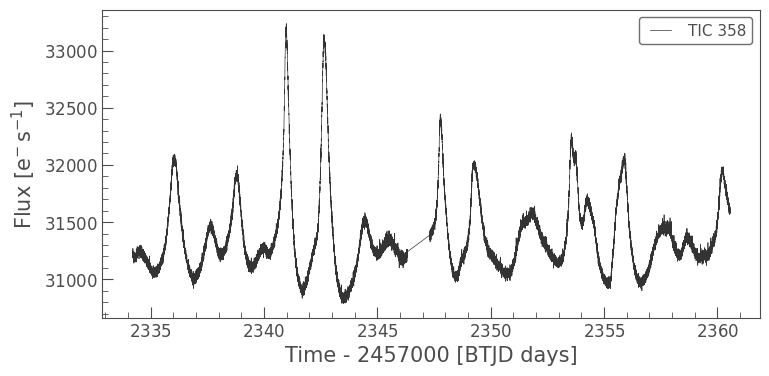

In [39]:
# Tracer la courbe de lumière
lc.plot()


In [43]:
print(lc.to_table())


       time             flux      ...   pos_corr1      pos_corr2   
                    electron / s  ...      pix            pix      
------------------ -------------- ... -------------- --------------
 2333.875907348336             -- ... -1.4423969e-03  1.8026277e-01
2333.8772962463872             -- ...  9.5719256e-04  1.7754285e-01
 2333.878685144438             -- ... -2.5004228e-03  1.8130247e-01
2333.8925741272747             -- ... -2.6825648e-03  1.7639801e-01
2333.8939630257905             -- ... -2.8626430e-03  1.7633481e-01
   2333.9245187885             -- ...             --             --
2333.9259076870167             -- ...             --             --
 2333.927296585068             -- ...             --             --
2333.9286854835846             -- ...             --             --
               ...            ... ...            ...            ...
2360.5437189812064  3.1627557e+04 ...  6.2346144e-04 -8.9570507e-02
2360.5451078275682  3.1602170e+04 ...  9.7454041